In [30]:
import numpy as np
from qutip import *
from qutip.core.gates import *
import json
import numpy as np
from numpy import real
from matplotlib import pyplot as plt
from numpy import array
from numpy import real


pi = np.pi

# -----------------------------------------------------------
# Utility functions
# -----------------------------------------------------------
def wc_t(t, args=None):
    return 1

def w1_t(t, args=None):
    if t > T0_1 and t <= T0_1 + T_gate_1:
        return 1
    else:
        return 0

def w2_t(t, args=None):
    if t > T0_2 and t <= T0_2 + T_gate_2:
        return 1
    else:
        return 0

def read_json_to_dict(filename: str) -> dict:
    with open(filename, 'r') as f:
        return json.load(f)

# -----------------------------------------------------------
# Load system parameters (LiH example)
# -----------------------------------------------------------
LiH_params = read_json_to_dict("LiH_params.json")
mu_eg = LiH_params["qubit_1_dipole_moments"]["mu_eg"]

Nf = 2  # bosonic cutoff
# local operators
sz = sigmaz()
sm = destroy(2)
sp = sm.dag()
nq = sp * sm

am = destroy(Nf)
ap = am.dag()
nc = ap * am

# identities
Iq = qeye(2)
Ic = qeye(Nf)
Iv = qeye(Nf)

# fixed frequencies
omega_q = LiH_params["w_q1"]
omega_c = omega_q  # enforce resonance
omega_v = LiH_params["w_vib1"]
print(f"omega_q = {omega_q}, omega_c = {omega_c}, omega_v = {omega_v}")

# initial state: |e,g,0,0,0>
psi0 = tensor(basis(2,1), basis(2,0), basis(Nf,0), basis(Nf,0), basis(Nf,0))

# ideal Bell target
rho_qubits_ideal = ket2dm(
    tensor(phasegate(0), phasegate(pi/2)) *
    sqrtiswap() *
    tensor(basis(2,1), basis(2,0))
)

# time discretization
tlist = np.linspace(0, 1400, 5000)

# bare Hamiltonian (independent of gc, gv)
H_q1 = tensor(-omega_q/2 * sz, Iq, Iv, Iv, Ic)
H_q2 = tensor(Iq, -omega_q/2 * sz, Iv, Iv, Ic)
H_v1 = tensor(Iq, Iq, omega_v * nc, Iv, Ic)
H_v2 = tensor(Iq, Iq, Iv, omega_v * nc, Ic)
H_cav = tensor(Iq, Iq, Iv, Iv, omega_c * nc)
H_bare_total = H_q1 + H_q2 + H_v1 + H_v2 + H_cav





# -----------------------------------------------------------
# Flexible objective configuration
# -----------------------------------------------------------
objective_mode = "weighted"   # options: "product" or "weighted"
alpha, beta = 0.5, 0.5       # only used if mode="weighted"

# -----------------------------------------------------------
# Objective function
# -----------------------------------------------------------
def objective(params):
    gc, gv = params
    gc = 0.00254
    gv = 0.0 

    # number operators for expectation values on composite space
    nq1  = tensor(nq, Iq, Iv, Iv, Ic)
    nq2  = tensor(Iq, nq, Iv, Iv, Ic)
    ncav = tensor(Iq, Iq, Iv, Iv, nc)

    # interaction terms
    H_q1_cav = gc * (tensor(sp, Iq, Iv, Iv, am) + tensor(sm, Iq, Iv, Iv, ap))
    H_q2_cav = gc * (tensor(Iq, sp, Iv, Iv, am) + tensor(Iq, sm, Iv, Iv, ap))

    H_q1_vib1 = gv * tensor(sp*sm, Iq, (am+ap), Iv, Ic)
    H_q2_vib2 = gv * tensor(Iq, sp*sm, Iv, (am+ap), Ic)

    H_bare_vc = H_bare_total + H_q1_vib1 + H_q2_vib2

    H_cav_local = ptrace(H_cav, [4])
    print(H_cav_local)
    H_q1_cav_local = ptrace(H_q1_cav, [0,4])
    print(H_q1_cav_local)
    H_q2_cav_local = ptrace(H_q2_cav, [1,4])
    print(H_q2_cav_local)   

    # gate times fixed by gc
    global T0_1, T0_2, T_gate_1, T_gate_2
    T0_1 = 20
    T_gate_1 = pi / (4 * np.abs(gc))
    T0_2 = T0_1 + T_gate_1
    T_gate_2 = pi / (2 * np.abs(gc))
    print(f"gc = {gc:.5f}, gv = {gv:.5f} => T_gate_1 = {T_gate_1:.2f}, T_gate_2 = {T_gate_2:.2f}")

    # time-dependent Hamiltonian
    H_t = [[H_bare_vc, wc_t],
           [H_q1_cav, w1_t],
           [H_q2_cav, w2_t]]

    res = mesolve(H_t, psi0, tlist, [], e_ops=[])


    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

    axes[0].plot(tlist, array(list(map(wc_t, tlist))), 'r', linewidth=2, label="cavity")
    axes[0].plot(tlist, array(list(map(w1_t, tlist))), 'b', linewidth=2, label="qubit 1")
    axes[0].plot(tlist, array(list(map(w2_t, tlist))), 'g', linewidth=2, label="qubit 2")
    #axes[0].set_ylim(1, 6)
    axes[0].set_ylabel("Energy (a.u.)", fontsize=16)
    axes[0].legend()

    axes[1].plot(tlist, real(expect(ncav, res.states)), 'r', linewidth=2, label="cavity")
    axes[1].plot(tlist, real(expect(nq1, res.states)), 'b', linewidth=2, label="qubit 1")
    axes[1].plot(tlist, real(expect(nq2, res.states)), 'g', linewidth=2, label="qubit 2")
    axes[1].set_xlabel("Time (a.u.)", fontsize=16)
    axes[1].set_ylabel("Occupation probability", fontsize=16)
    axes[1].legend()

    fig.tight_layout()


    rho_final = res.states[-1]

    rho_qubits = ptrace(rho_final, [0,1])
    print(rho_qubits)
    fide = fidelity(rho_qubits, rho_qubits_ideal)
    conc = concurrence(rho_qubits)

    # store for inspection
    objective.last_fid = fide
    objective.last_conc = conc

    # choose objective type
    if objective_mode == "product":
        score = fide * conc
    elif objective_mode == "weighted":
        score = alpha * fide + beta * conc
    else:
        raise ValueError("objective_mode must be 'product' or 'weighted'")

    return -score  # minimize negative to maximize

omega_q = 0.12086, omega_c = 0.12086, omega_v = 0.00622913


Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dia, isherm=True
Qobj data =
[[0.      0.     ]
 [0.      1.93376]]
Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dia, isherm=True
Qobj data =
[[0.      0.      0.      0.     ]
 [0.      0.      0.02032 0.     ]
 [0.      0.02032 0.      0.     ]
 [0.      0.      0.      0.     ]]
Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dia, isherm=True
Qobj data =
[[0.      0.      0.      0.     ]
 [0.      0.      0.02032 0.     ]
 [0.      0.02032 0.      0.     ]
 [0.      0.      0.      0.     ]]
gc = 0.00254, gv = 0.00000 => T_gate_1 = 309.21, T_gate_2 = 618.42
Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 3.83942110e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  5.00003472e-01 -5.00000000e-01  0.00000000e+00]
 [ 0.00000000e+00 -5.00000000e-01  4.99996528e-01  0.00000000e+00]
 [ 0.000000

np.float64(-1.0000000011235644)

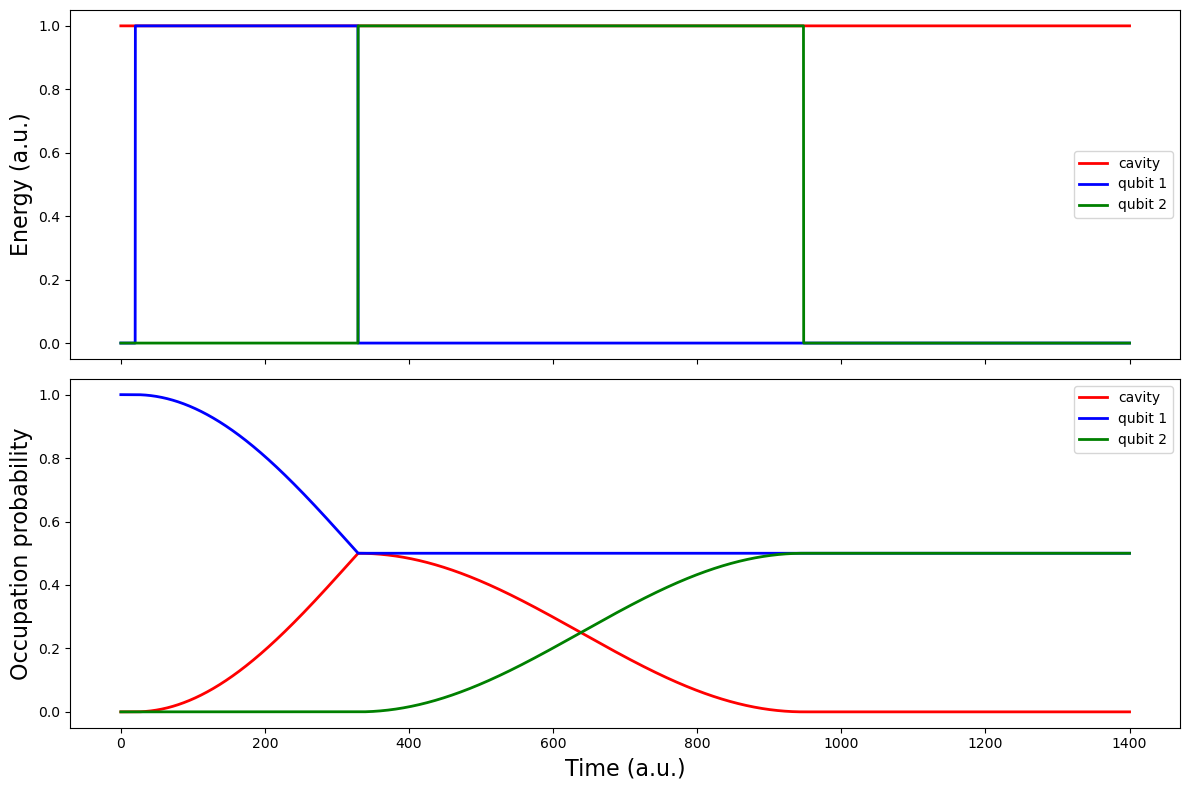

In [31]:
in_params = [0.002541, 0.0]
objective((in_params[0], in_params[1]))